In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pip install tensorflow==2.15.0 tensorflow-hub keras==2.15.0

Note: you may need to restart the kernel to use updated packages.


In [3]:
import datetime 
print(f"Notebook last run is :{datetime.datetime.now()}")

Notebook last run is :2024-12-16 14:53:55.976799


In [4]:
# check for gpu 
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-17c9c4f4-4d53-b039-f4a4-cd0dde485639)


In [5]:
# Get helper functions 
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-12-16 14:53:57--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: 'helper_functions.py.3'

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-12-16 14:53:58 (22.3 MB/s) - 'helper_functions.py.3' saved [10246/10246]



In [6]:
# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

2024-12-16 14:53:58.576591: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-16 14:53:58.576650: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-16 14:53:58.578393: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Download A Text Dataset 

In [7]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-12-16 14:54:02--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.207, 172.253.117.207, 74.125.135.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: 'nlp_getting_started.zip.3'

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2024-12-16 14:54:02 (103 MB/s) - 'nlp_getting_started.zip.3' saved [607343/607343]



# Visualizing a text datasett

In [8]:

# Turn .csv files into pandas DataFrame's
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:

# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [10]:
# The test data doesn't have a target (that's what we'd try to predict)
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [11]:

# How many examples of each class?
train_df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

* 1 = a real disaster Tweet* 
0 = not a real disaster Tweet

In [12]:

# How many samples total?
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [13]:

# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
'The man who can drive himself further once the effort gets painful is the man who will win.' 
Roger Bannister

---

Target: 0 (not real disaster)
Text:
Why are you engulfed by low self-image? Take the quiz: http://t.co/I9dSPDKrUK http://t.co/NEp5aZwKNA

---

Target: 1 (real disaster)
Text:
Cuban leader extends sympathy to Vietnam over flooding at http://t.co/xLq8G6vb2r

---

Target: 0 (not real disaster)
Text:
CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring

---

Target: 1 (real disaster)
Text:
#reno Truck trailer catches fire in Reno http://t.co/k5FIJaNkJb

---



# Split data into training and validation sets

In [14]:
X=train_df_shuffled['text'].to_numpy()
y=train_df_shuffled['target'].to_numpy()

In [15]:
from sklearn.model_selection import train_test_split 

train_sentences,val_sentences,train_labels,val_labels=train_test_split(X,y,test_size=0.1,random_state=42)

In [16]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [17]:
# View the first 10 training sentences and their labels
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

# Converting text into numbers

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization # after TensorFlow 2.6

# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

In [19]:
# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [20]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [21]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [22]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [23]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
Meek Mill responds to DrakeÛªs OVO Fest set with wedgie threat http://t.co/qqSKYbARNg      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 770, 1812, 2316,    5,    1, 4970, 5651,  284,   14, 6866, 1170,
           1,    0,    0,    0]])>

In [24]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


# Creating an Embedding using an Embedding Layer

In [25]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1") 

embedding

In [26]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
Accident with injuries on #NJ36 SB at CR 516/Leonardville Rd http://t.co/2xwIHy2wsg      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.02617638, -0.0038172 , -0.04375166, ...,  0.0204281 ,
          0.03586761,  0.03729384],
        [ 0.02582939, -0.00722962,  0.04644514, ..., -0.02274377,
         -0.04101709,  0.04942168],
        [-0.04394467, -0.04161898,  0.0491373 , ..., -0.03271188,
          0.0405697 , -0.01909778],
        ...,
        [-0.01341619, -0.0054267 ,  0.01155552, ...,  0.00323222,
         -0.02983447, -0.01663388],
        [-0.01341619, -0.0054267 ,  0.01155552, ...,  0.00323222,
         -0.02983447, -0.01663388],
        [-0.01341619, -0.0054267 ,  0.01155552, ...,  0.00323222,
         -0.02983447, -0.01663388]]], dtype=float32)>

In [27]:
# Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.02617638, -0.0038172 , -0.04375166,  0.02253075,  0.03558568,
       -0.00915722, -0.01429017, -0.04552522, -0.04230552,  0.00877283,
       -0.00102011,  0.02146747,  0.01433532, -0.03466579, -0.03930686,
       -0.02258453, -0.00304813,  0.03360537, -0.0306284 ,  0.01620061,
       -0.02593371,  0.03194064,  0.03881464,  0.04589475,  0.04869205,
       -0.03977344, -0.02168874,  0.02566544, -0.04700465,  0.0147273 ,
        0.01311618, -0.04909769, -0.01812719, -0.00821037, -0.04469292,
       -0.03948621,  0.0395376 ,  0.03859464, -0.0172845 , -0.00345973,
        0.00102421, -0.04001869,  0.01898153,  0.02307887,  0.01396764,
       -0.0410346 , -0.01331485,  0.015333  , -0.02214906,  0.00632852,
       -0.04620233,  0.0167299 , -0.01819335, -0.00939177,  0.02121141,
        0.02740199,  0.04386084,  0.00138379,  0.01251551, -0.01061086,
        0.04241182, -0.02681384,  0.0241829 ,  0.03877657,  0.02211011,
        0.047476

* Model 0: Naive Bayes (baseline)
* Model 1: Feed-forward neural network (dense model
* Model 2: LSTM mode*
* Model 3: GRU mod* 
* Model 4: Bidirectional-LSTM mo* d
* Model 5: 1D Convolutional Neural Net* wo
* Model 6: TensorFlow Hub Pretrained Feature Extr* act
* Model 7: Same as model 6 with 10% of traini

# Model 0: Getting a baseline

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [29]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


<!--  -->

In [30]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an Evaluation Function for Our Model Experiments

- **Metrics to Include:**
  - Accuracy
  - Precision
  - Recall
  - F1-Score
e



In [31]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [32]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

# Model 1: A simple dense model

In [33]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [34]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [35]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [36]:
# Get a summary of the model
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [37]:
# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20241216-145405
Epoch 1/5


I0000 00:00:1734360847.106974    1740 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


215/215 [==============================] - 7s 28ms/step - loss: 0.6094 - accuracy: 0.6922 - val_loss: 0.5359 - val_accuracy: 0.7546
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.4407 - accuracy: 0.8193 - val_loss: 0.4693 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 2s 7ms/step - loss: 0.3458 - accuracy: 0.8609 - val_loss: 0.4593 - val_accuracy: 0.7927
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2843 - accuracy: 0.8924 - val_loss: 0.4647 - val_accuracy: 0.7887
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2374 - accuracy: 0.9117 - val_loss: 0.4773 - val_accuracy: 0.7861


In [38]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4773 - accuracy: 0.7861


[0.4772925078868866, 0.7860892415046692]

In [39]:
embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[ 0.00837613,  0.01478075, -0.00897421, ..., -0.01646583,
         -0.01375444,  0.00240804],
        [-0.01933802,  0.0402579 , -0.03072772, ..., -0.00605411,
          0.04648878,  0.02944293],
        [ 0.02155711,  0.03052171, -0.02534594, ...,  0.019492  ,
         -0.0229909 ,  0.01634218],
        ...,
        [ 0.01932944,  0.01171603,  0.02295896, ..., -0.01167611,
         -0.02096304, -0.00378394],
        [ 0.03998637,  0.07740236, -0.04790734, ..., -0.03696226,
          0.0925164 ,  0.02566947],
        [ 0.10795049,  0.06306051, -0.0468661 , ..., -0.03231452,
          0.08021884,  0.02277734]], dtype=float32)>]

In [40]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [41]:
# # View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# # Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./model_logs \
#   --name "First deep model on text data" \
#   --description "Trying a dense model with an embedding layer" \
#   --one_shot # exits the uploader when upload has finished

In [42]:
# Make predictions (these come back in the form of probabilities)
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10] # only print out the first 10 prediction probabilities

24/24 [==============================] - 0s 2ms/step


array([[0.4183246 ],
       [0.7458781 ],
       [0.9977441 ],
       [0.10826848],
       [0.11105882],
       [0.935012  ],
       [0.9092122 ],
       [0.9929583 ],
       [0.96742725],
       [0.26646945]], dtype=float32)

In [43]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [44]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.60892388451444,
 'precision': 0.7903277546022673,
 'recall': 0.7860892388451444,
 'f1': 0.7832971347503846}

In [45]:
# Is our simple Keras model better than our baseline model?
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

In [46]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results, 
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 78.61, Difference: -0.66
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.00


In [47]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [48]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [49]:
# Get the weight matrix of embedding layer 
# (these are the numerical patterns between the text in the training dataset the model has learned)
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim (each word is a embedding_dim size vector)

(10000, 128)


In [50]:
# # Code below is adapted from: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
# import io

# # Create output writers
# out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
# out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# # Write embedding vectors and words to file
# for num, word in enumerate(words_in_vocab):
#   if num == 0: 
#      continue # skip padding token
#   vec = embed_weights[num]
#   out_m.write(word + "\n") # write words to file
#   out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
# out_v.close()
# out_m.close()

# # Download files locally to upload to Embedding Projector
# try:
#   from google.colab import files
# except ImportError:
#   pass
# else:
#   files.download("embedding_vectors.tsv")
#   files.download("embedding_metadata.tsv")

# Recurrent Neural Networks (RNN's)

# Model 2: LSTMM

In [51]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [52]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [53]:

model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [54]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20241216-145420
Epoch 1/5
215/215 [==============================] - 9s 32ms/step - loss: 0.5092 - accuracy: 0.7434 - val_loss: 0.4561 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3163 - accuracy: 0.8704 - val_loss: 0.5086 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2182 - accuracy: 0.9165 - val_loss: 0.5763 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.1542 - accuracy: 0.9453 - val_loss: 0.6280 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1073 - accuracy: 0.9603 - val_loss: 0.8676 - val_accuracy: 0.7585


In [55]:

# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10] # view the first 10

24/24 [==============================] - 0s 3ms/step


((762, 1),
 array([[0.01342538],
        [0.7424405 ],
        [0.99953604],
        [0.07263171],
        [0.00276842],
        [0.99958736],
        [0.9202849 ],
        [0.9998098 ],
        [0.99973565],
        [0.2794292 ]], dtype=float32))

In [56]:

# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [57]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 75.8530183727034,
 'precision': 0.7592089134633101,
 'recall': 0.7585301837270341,
 'f1': 0.7567321197360164}

In [58]:
# Compare model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.27, New accuracy: 75.85, Difference: -3.41
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.03


# Model 3: GRU  ( Gated Recurrent Unit)

In [59]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x) 
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [60]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [61]:

# Get a summary of the GRU model
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [62]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20241216-145437
Epoch 1/5
215/215 [==============================] - 9s 31ms/step - loss: 0.5213 - accuracy: 0.7357 - val_loss: 0.4576 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3161 - accuracy: 0.8718 - val_loss: 0.4945 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2165 - accuracy: 0.9172 - val_loss: 0.5669 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.1545 - accuracy: 0.9463 - val_loss: 0.6232 - val_accuracy: 0.7808
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1175 - accuracy: 0.9602 - val_loss: 0.6060 - val_accuracy: 0.7703


In [63]:

# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


((762, 1),
 array([[0.2872044 ],
        [0.88335896],
        [0.9962134 ],
        [0.15902786],
        [0.01330172],
        [0.9904587 ],
        [0.82550675],
        [0.99690527],
        [0.9965641 ],
        [0.4588744 ]], dtype=float32))

In [64]:

# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [65]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 77.03412073490814,
 'precision': 0.7701208199177533,
 'recall': 0.7703412073490814,
 'f1': 0.7695203715374298}

In [66]:

# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy: 77.03, Difference: -2.23
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


# Model 4: Bidirectonal RNN model

In [67]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [68]:

# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [69]:

# Get a summary of our bidirectional model
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable par

In [70]:
# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20241216-145453
Epoch 1/5
215/215 [==============================] - 11s 33ms/step - loss: 0.5054 - accuracy: 0.7494 - val_loss: 0.4567 - val_accuracy: 0.7861
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3107 - accuracy: 0.8752 - val_loss: 0.5212 - val_accuracy: 0.7664
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2105 - accuracy: 0.9193 - val_loss: 0.5721 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1448 - accuracy: 0.9510 - val_loss: 0.6492 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1026 - accuracy: 0.9644 - val_loss: 0.6837 - val_accuracy: 0.7717


In [71]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]



24/24 [==============================] - 1s 3ms/step


array([[0.00931266],
       [0.834033  ],
       [0.99925464],
       [0.10360009],
       [0.00257293],
       [0.9928422 ],
       [0.61884505],
       [0.99967825],
       [0.9993599 ],
       [0.28477925]], dtype=float32)

In [72]:

# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [73]:

# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 77.16535433070865,
 'precision': 0.7741380916586217,
 'recall': 0.7716535433070866,
 'f1': 0.7691811868378113}

In [74]:
# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 77.17, Difference: -2.10
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


# Convolutional Neural Networks for Textt

# Model 5: Conv1D

In [75]:
# Test out the embedding, 1D convolutional and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu") # convolve over target sequence 5 words at a time
conv_1d_output = conv_1d(embedding_test) # pass embedding through 1D convolutional layer
max_pool = layers.GlobalMaxPool1D() 
max_pool_output = max_pool(conv_1d_output) # get the most important features
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [76]:

# See the outputs of each layer
embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[-0.00337757,  0.01580439, -0.00330688, ..., -0.00505561,
          -0.03076832, -0.01986178],
         [ 0.09071158,  0.06835745, -0.06917748, ..., -0.05726859,
           0.07758676,  0.04780914],
         [-0.00325714, -0.01622566,  0.01067099, ..., -0.00976208,
          -0.04103972,  0.01339092],
         ...,
         [ 0.00837613,  0.01478075, -0.00897421, ..., -0.01646583,
          -0.01375444,  0.00240804],
         [ 0.00837613,  0.01478075, -0.00897421, ..., -0.01646583,
          -0.01375444,  0.00240804],
         [ 0.00837613,  0.01478075, -0.00897421, ..., -0.01646583,
          -0.01375444,  0.00240804]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[0.09106469, 0.05833508, 0.        , 0.08155195, 0.        ,
          0.00347798, 0.00807413, 0.05958623, 0.        , 0.02088941,
          0.        , 0.        , 0.05015577, 0.08960997, 0.        ,
          0.00032704, 0.

In [77]:

# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 1)              

In [78]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20241216-145513
Epoch 1/5
215/215 [==============================] - 7s 28ms/step - loss: 0.5651 - accuracy: 0.7162 - val_loss: 0.4720 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3419 - accuracy: 0.8586 - val_loss: 0.4702 - val_accuracy: 0.7913
Epoch 3/5
215/215 [==============================] - 2s 7ms/step - loss: 0.2132 - accuracy: 0.9203 - val_loss: 0.5338 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1345 - accuracy: 0.9559 - val_loss: 0.6182 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0957 - accuracy: 0.9685 - val_loss: 0.6673 - val_accuracy: 0.7927


In [79]:

# Make predictions with model_5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.46144873],
       [0.7496782 ],
       [0.99976283],
       [0.10853068],
       [0.00699216],
       [0.99174833],
       [0.8948215 ],
       [0.99737346],
       [0.99921906],
       [0.34674957]], dtype=float32)

In [80]:

# Convert model_5 prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [81]:

# Calculate model_5 evaluation metrics 
model_5_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 79.26509186351706,
 'precision': 0.7940421644330903,
 'recall': 0.7926509186351706,
 'f1': 0.7911069289037533}

In [82]:
# Compare model_5 results to baseline 
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 79.27, New accuracy: 79.27, Difference: 0.00
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: 0.00
Baseline f1: 0.79, New f1: 0.79, Difference: 0.00


# Using Pretrained Embeddings (transfer learning for NLP))

# Model 6: TensorFlow Hub Pretrained Sentence Encoder

In [83]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157032  0.02485909  0.02878048 -0.01271501  0.03971539  0.0882776
  0.02680985  0.05589837 -0.0106873  -0.00597291  0.00639325 -0.0181952
  0.00030816  0.09105889  0.05874643 -0.03180627  0.01512473 -0.05162929
  0.00991365 -0.06865346 -0.04209305  0.02678981  0.03011008  0.00321067
 -0.0033797  -0.04787361  0.02266722 -0.00985925 -0.04063613 -0.0129209
 -0.04666385  0.056303   -0.03949255  0.00517688  0.02495828 -0.07014443
  0.02871508  0.04947681 -0.00633976 -0.08960193  0.02807116 -0.00808363
 -0.01360604  0.0599865  -0.10361787 -0.05195372  0.00232956 -0.02332528
 -0.03758106  0.03327731], shape=(50,), dtype=float32)


In [84]:
# Each sentence has been encoded into a 512 dimension vector
embed_samples[0].shape

TensorShape([512])

In [85]:
import keras
from keras.layers import Dense
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras

In [86]:
# !pip install tf_keras -q  # notice -q for quiet installation (maybe it is not needed as it could be installed properly)

In [87]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE") 

In [88]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [92]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20241216-151137
Epoch 1/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2239 - accuracy: 0.9165 - val_loss: 0.4675 - val_accuracy: 0.8163
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2155 - accuracy: 0.9203 - val_loss: 0.4762 - val_accuracy: 0.8136
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2063 - accuracy: 0.9253 - val_loss: 0.4752 - val_accuracy: 0.8084
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1986 - accuracy: 0.9296 - val_loss: 0.4852 - val_accuracy: 0.8058
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1905 - accuracy: 0.9323 - val_loss: 0.4918 - val_accuracy: 0.8084


In [93]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 8ms/step


array([[0.0705739 ],
       [0.7234912 ],
       [0.9987404 ],
       [0.09978659],
       [0.5311377 ],
       [0.7870621 ],
       [0.9978642 ],
       [0.9996171 ],
       [0.9879275 ],
       [0.01023917]], dtype=float32)

In [94]:

# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [95]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 80.83989501312337,
 'precision': 0.8128660178043178,
 'recall': 0.8083989501312336,
 'f1': 0.8060852157337799}

In [96]:
# Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, New accuracy: 80.84, Difference: 1.57
Baseline precision: 0.81, New precision: 0.81, Difference: 0.00
Baseline recall: 0.79, New recall: 0.81, Difference: 0.02
Baseline f1: 0.79, New f1: 0.81, Difference: 0.02


# Model 7: TensorFlow Hub Pretrained Sentence Encoder 10% of the training data

In [97]:
# One kind of correct way (there are more) to make data subset
# (split the already split train_sentences/train_labels)
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)

In [98]:
# Check length of 10 percent datasets
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6851
Length of 10% training examples: 686


In [99]:
# Check the number of targets in our subset of data 
# (this should be close to the distribution of labels in the original train_labels)
pd.Series(train_labels_10_percent).value_counts()

0    415
1    271
Name: count, dtype: int64

In [100]:
# Clone model_6 but reset weights
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [101]:
# Fit the model to 10% of the training data
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20241216-151742
Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tf_keras.src.initializers.initializers.GlorotUniform'>, which may lead to improper serialization.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tf_keras.src.initializers.initializers.Zeros'>, which may lead to improper serialization.
  warnings.warn(


22/22 [==============================] - 3s 37ms/step - loss: 0.6652 - accuracy: 0.7026 - val_loss: 0.6445 - val_accuracy: 0.7060
Epoch 2/5
22/22 [==============================] - 0s 18ms/step - loss: 0.5906 - accuracy: 0.8120 - val_loss: 0.5874 - val_accuracy: 0.7415
Epoch 3/5
22/22 [==============================] - 0s 18ms/step - loss: 0.5136 - accuracy: 0.8192 - val_loss: 0.5343 - val_accuracy: 0.7717
Epoch 4/5
22/22 [==============================] - 0s 18ms/step - loss: 0.4506 - accuracy: 0.8338 - val_loss: 0.5039 - val_accuracy: 0.7730
Epoch 5/5
22/22 [==============================] - 0s 18ms/step - loss: 0.4087 - accuracy: 0.8324 - val_loss: 0.4879 - val_accuracy: 0.7808


In [102]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 0s 7ms/step


array([[0.26093888],
       [0.8121625 ],
       [0.90103734],
       [0.3051526 ],
       [0.56815267],
       [0.82860523],
       [0.81639844],
       [0.86237454],
       [0.8464553 ],
       [0.11237769]], dtype=float32)

In [103]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [104]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 78.08398950131233,
 'precision': 0.7852692803643447,
 'recall': 0.7808398950131233,
 'f1': 0.77783229852174}

In [105]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 79.27, New accuracy: 78.08, Difference: -1.18
Baseline precision: 0.81, New precision: 0.79, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


# Comparing the performance of each of our models

In [106]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.608924,0.790328,0.786089,0.783297
lstm,75.853018,0.759209,0.758530,0.756732
gru,77.034121,0.770121,0.770341,0.769520
bidirectional,77.165354,0.774138,0.771654,0.769181
conv1d,79.265092,0.794042,0.792651,0.791107
tf_hub_sentence_encoder,80.839895,0.812866,0.808399,0.806085
tf_hub_10_percent_data,78.083990,0.785269,0.780840,0.777832


In [107]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

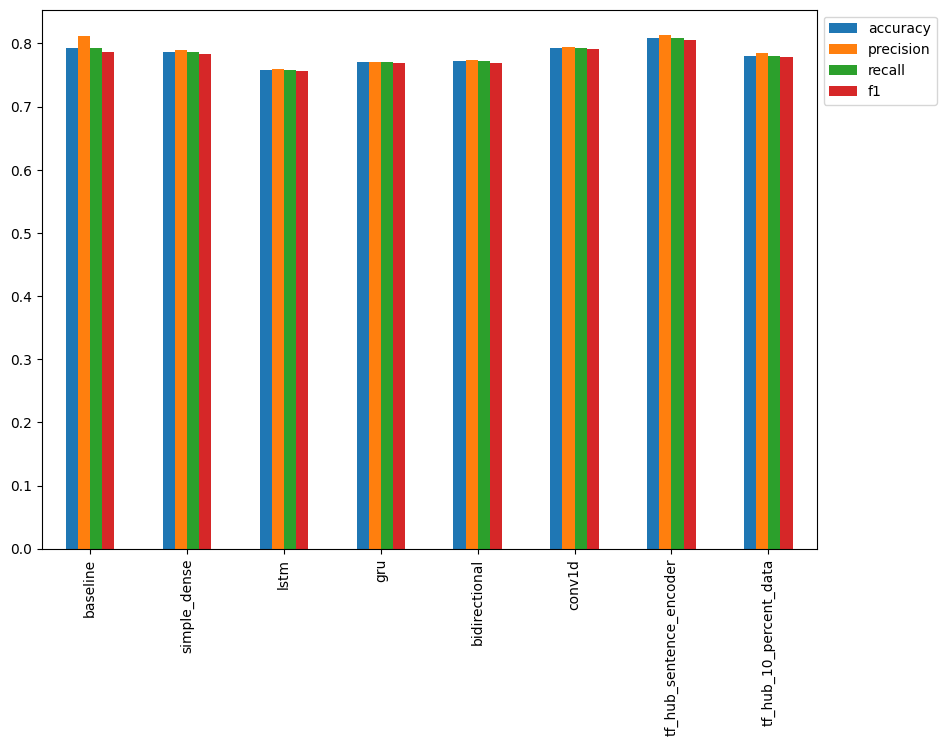

In [108]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

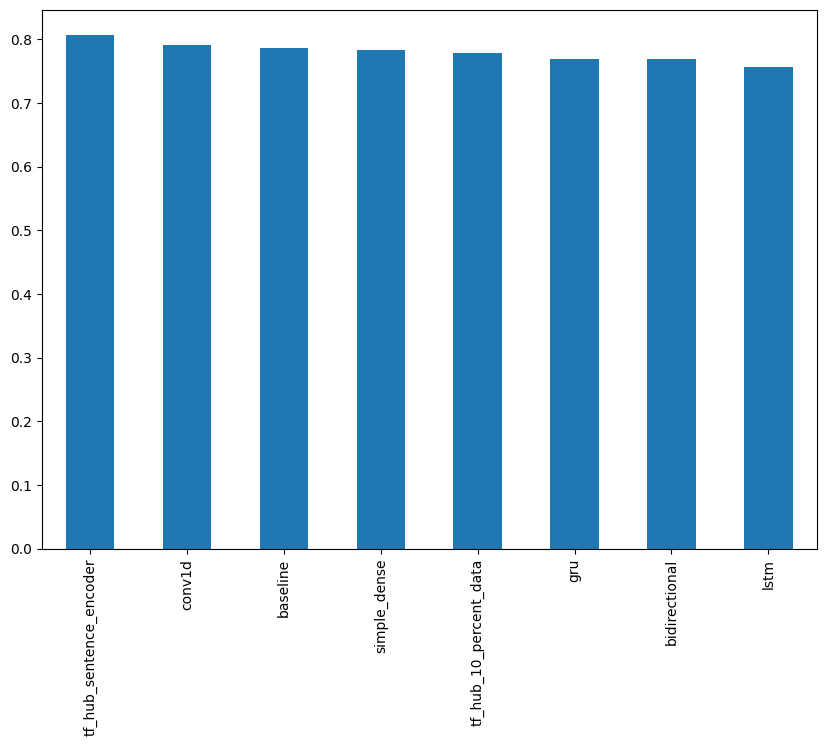

In [109]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

# Combining our models (model ensembling/stacking)

In [110]:
# Get mean pred probs for 3 models
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [111]:
# Calculate results from averaging the prediction probabilities
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 78.4776902887139,
 'precision': 0.7844679626314316,
 'recall': 0.7847769028871391,
 'f1': 0.7844262888191608}

In [112]:
# Add our combined model's results to the results DataFrame
all_model_results.loc["ensemble_results"] = ensemble_results

In [113]:
# Convert the accuracy to the same scale as the rest of the results
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100

/tmp/ipykernel_1675/3504904892.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100


In [114]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.786089,0.790328,0.786089,0.783297
lstm,0.758530,0.759209,0.758530,0.756732
gru,0.770341,0.770121,0.770341,0.769520
bidirectional,0.771654,0.774138,0.771654,0.769181
conv1d,0.792651,0.794042,0.792651,0.791107
tf_hub_sentence_encoder,0.808399,0.812866,0.808399,0.806085
tf_hub_10_percent_data,0.780840,0.785269,0.780840,0.777832
ensemble_results,78.477690,0.784468,0.784777,0.784426


# Saving and loading a trained model

In [115]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [116]:
# Load model with custom Hub Layer (required with HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5", 
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [117]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 8ms/step - loss: 0.4918 - accuracy: 0.8084


[0.4917726218700409, 0.808398962020874]

In [118]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")

In [119]:
# Load TF Hub Sentence Encoder SavedModel
loaded_model_6_SavedModel = tf.keras.models.load_model("model_6_SavedModel_format")

In [120]:
# Evaluate loaded SavedModel format
loaded_model_6_SavedModel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 8ms/step - loss: 0.4918 - accuracy: 0.8084


[0.4917726218700409, 0.808398962020874]

## Finding the most wrong examples

In [121]:
# Create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.070574
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.723491
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.998740
3,@camilacabello97 Internally and externally scr...,1,0.0,0.099787
4,Radiation emergency #preparedness starts with ...,1,1.0,0.531138


In [122]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
628,@noah_anyname That's where the concentration c...,0,1.0,0.990590
381,Deaths 3 http://t.co/nApviyGKYK,0,1.0,0.966488
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.963147
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.940860
303,Trafford Centre film fans angry after Odeon ci...,0,1.0,0.932725
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.922480
741,#helpme what do I do? My friend has been ticke...,0,1.0,0.914923
237,Came across this fire video not mine..enjoy..B...,0,1.0,0.901919
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.899879
253,Evacuation drill at work. The fire doors would...,0,1.0,0.898453


In [123]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9905904531478882
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1, Prob: 0.9664880633354187
Text:
Deaths 3 http://t.co/nApviyGKYK

----

Target: 0, Pred: 1, Prob: 0.9631473422050476
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.9408599138259888
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target: 0, Pred: 1, Prob: 0.9327251315116882
Text:
Trafford Centre film fans angry after Odeon cinema evacuated following false fire alarm   http://t.co/6GLDwx71DA

----

Target: 0, Pred: 1, Prob: 0.9224804043769836
Text:
[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES WITH MAGNE-TRACTION INSTRUCTIONS http://t.co/xEZBs3sq0y http://t.co/C2x0QoKGlY

----

Target: 0, Pred: 1, Prob: 0.9149225950241089
Text:
#helpme what do I do? My friend has been ticketed by Police in Wayne Coun

In [124]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.018120525404810905
Text:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0, Prob: 0.017378613352775574
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0, Prob: 0.016195006668567657
Text:
New post from @darkreading http://t.co/8eIJDXApnp New SMB Relay Attack Steals User Credentials Over Internet

----

Target: 1, Pred: 0, Prob: 0.014649289660155773
Text:
Reddit Will Now QuarantineÛ_ http://t.co/pkUAMXw6pm #onlinecommunities #reddit #amageddon #freespeech #Business http://t.co/PAWvNJ4sAP

----

Target: 1, Pred: 0, Prob: 0.011755675077438354
Text:
Yelp Bolsters Health Care Reviews With Investigative Journalism: Sick and injured patients at a local ER are t... http://t.co/E8aEGOFDY2

----

Target: 1, Pred: 0, Prob: 0.009459486231207848
Text:
Next May I'll be free...from school from obligations like family.... Best of all that damn curfew...

----

Target: 1,

In [125]:
# Making predictions on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample])) # has to be list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

1/1 [==============================] - 0s 37ms/step
Pred: 1, Prob: 0.9973904490470886
Text:
Flood Advisory issued August 05 at 4:35PM EDT by NWS http://t.co/fuZ7y44P4I #WxKY

----

1/1 [==============================] - 0s 35ms/step
Pred: 0, Prob: 0.017163561657071114
Text:
@spinningbot Are you another Stand-user? If you are I will have to detonate you with my Killer Queen.

----

1/1 [==============================] - 0s 33ms/step
Pred: 0, Prob: 0.3620798885822296
Text:
??Water fight??
Penn park 6pm 
      BYOW
(Bring Your Own Weapons)

----

1/1 [==============================] - 0s 34ms/step
Pred: 0, Prob: 0.01837613619863987
Text:
@DancingOnHwy there is nothing I love more than seeing Bears fans get their hopes and dreams crushed.

----

1/1 [==============================] - 0s 40ms/step
Pred: 0, Prob: 0.020965704694390297
Text:
World War II book LIGHTNING JOE An Autobiography by General J. Lawton Collins http://t.co/ihxkforg4I http://t.co/jD6lcRuOHA

----

1/1 [==================

In [126]:
# Turn Tweet into string
daniels_tweet = "Life like an ensemble: take the best choices from others and make your own"

In [127]:
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [128]:
# Make a prediction on Tweet from the wild
predict_on_sentence(model=model_6, # use the USE model
                    sentence=daniels_tweet)

1/1 [==============================] - 0s 39ms/step
Pred: 0.0 (not real disaster) Prob: 0.07541303336620331
Text:
Life like an ensemble: take the best choices from others and make your own


In [129]:
# Source - https://twitter.com/BeirutCityGuide/status/1290696551376007168
beirut_tweet_1 = "Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon"

# Source - https://twitter.com/BeirutCityGuide/status/1290773498743476224
beirut_tweet_2 = "#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon"

In [130]:
# Predict on diaster Tweet 1
predict_on_sentence(model=model_6, 
                    sentence=beirut_tweet_1)

1/1 [==============================] - 0s 35ms/step
Pred: 1.0 (real disaster) Prob: 0.9944688081741333
Text:
Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon


In [131]:
# Predict on diaster Tweet 2
predict_on_sentence(model=model_6, 
                    sentence=beirut_tweet_2)

1/1 [==============================] - 0s 35ms/step
Pred: 1.0 (real disaster) Prob: 0.9967671632766724
Text:
#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon


## The speed/score tradeoff

In [132]:
# Calculate the time of predictions
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  
  Args:
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(val_sentences) # find prediction time per sample
  return total_time, time_per_pred

In [133]:
# Calculate TF Hub Sentence Encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 7ms/step


(0.2451599409996561, 0.0003217322060362941)

In [134]:
# Calculate Naive Bayes prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.013236812999821268, 1.7371145669056783e-05)

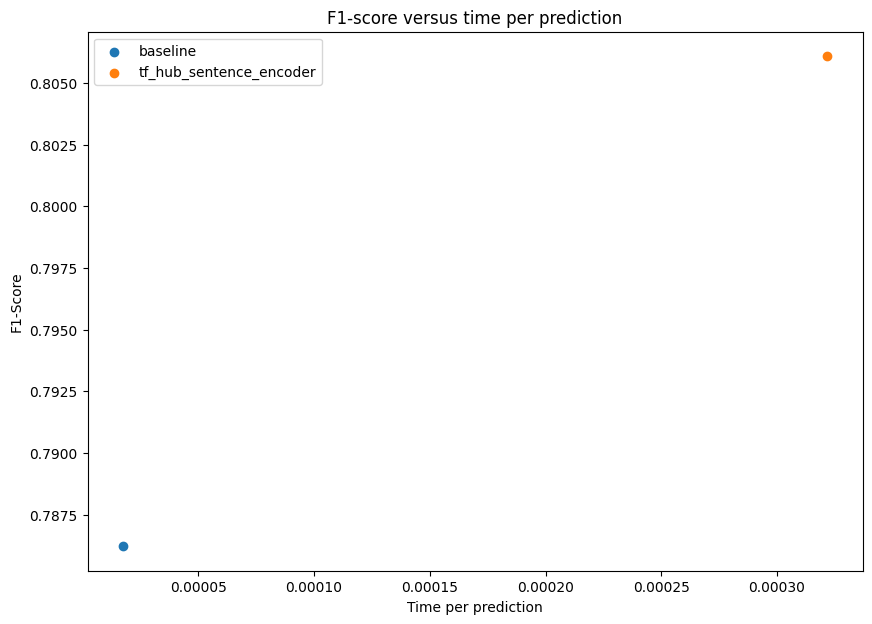

In [135]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");

**End**